<h1><center>Лабораторная работа №5 "Линейная регрессия".</center></h1>
<h2><center>Вахлаева Марина Олеговна, гр. 6131-010402D</center></h2>

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score

### 1. Считать в pandas.DataFrame любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.

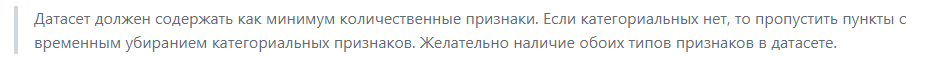

In [2]:
path = 'C:/Users/PC/Downloads/Python/TAI/datasets/'

df = pd.read_csv(Path(path, 'diabetes_prediction_dataset.csv'))

In [3]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


### 2. Датасет и подготовка данных, этап 1:

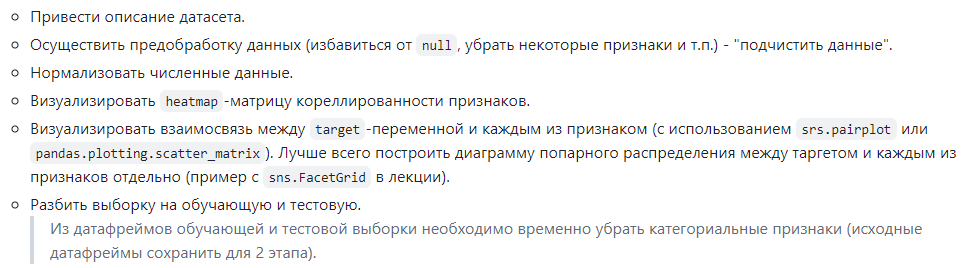

#### Описание датасета

Для бинарной классификации будет использоваться набор данных для прогнозирования диабета. 

Датасет представляет собой совокупность медицинских и демографических данных пациентов, а также их статуса диабета (положительного или отрицательного). Этот набор данных можно использовать для создания моделей машинного обучения для прогнозирования диабета у пациентов на основе их истории болезни и демографической информации. Это может быть полезно для медицинских работников при выявлении пациентов, которые могут подвергаться риску развития диабета, и при разработке индивидуальных планов лечения. Кроме того, набор данных может быть использован исследователями для изучения взаимосвязи между различными медицинскими и демографическими факторами и вероятностью развития диабета.

Ссылка на датасет: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data
        
|       Признак       |       Расшифровка      |
|---------------------|------------------------|
| gender              |Пол                     |
| age                 |Возраст                 | 
| hypertension        |Гипертония              | 
| heart_disease       |Болезни сердца          | 
| smoking_history     |История курения         |
| bmi                 |Индекс массы тела       |
| HbA1c_level         |Уровень HbA1c           | 
| blood_glucose_level |Уровень глюкозы в крови |
| diabetes            |Диабет                  | 

#### Предобработка данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


NaN значения отсутсвуют в данных. Можно сказать, что к категориальным признакам относятся "gender" и "smoking_history"

In [5]:
# Дропнем таргет
df_1 = df.drop('diabetes', axis=1, inplace=False)
df_1

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,Female,80.0,0,1,never,25.19,6.6,140
1,Female,54.0,0,0,No Info,27.32,6.6,80
2,Male,28.0,0,0,never,27.32,5.7,158
3,Female,36.0,0,0,current,23.45,5.0,155
4,Male,76.0,1,1,current,20.14,4.8,155
...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90
99996,Female,2.0,0,0,No Info,17.37,6.5,100
99997,Male,66.0,0,0,former,27.83,5.7,155
99998,Female,24.0,0,0,never,35.42,4.0,100


In [6]:
df['diabetes'].value_counts() # Видно, что присуствует дисбаланс классов

diabetes
0    91500
1     8500
Name: count, dtype: int64

Закодируем категориальные признаки

In [7]:
df_1["gender"] = df_1["gender"].replace({'Female': int(0), 'Male': int(1), 'Other': int(2)}) 
df_1["smoking_history"] = df_1["smoking_history"].replace({'No Info': int(0), 'never': int(1), 'former': int(2), 'current': int(3), 'not current': int(4), 'ever': int(5)}) 

In [8]:
df_1

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,0,80.0,0,1,1,25.19,6.6,140
1,0,54.0,0,0,0,27.32,6.6,80
2,1,28.0,0,0,1,27.32,5.7,158
3,0,36.0,0,0,3,23.45,5.0,155
4,1,76.0,1,1,3,20.14,4.8,155
...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,0,27.32,6.2,90
99996,0,2.0,0,0,0,17.37,6.5,100
99997,1,66.0,0,0,2,27.83,5.7,155
99998,0,24.0,0,0,1,35.42,4.0,100


Нормализация данных

In [9]:
all_cols = list(df_1.columns)
mm_scaler = MinMaxScaler()
features_scaled = mm_scaler.fit_transform(df_1[all_cols])
df_sc1 = pd.DataFrame(features_scaled, columns=all_cols)

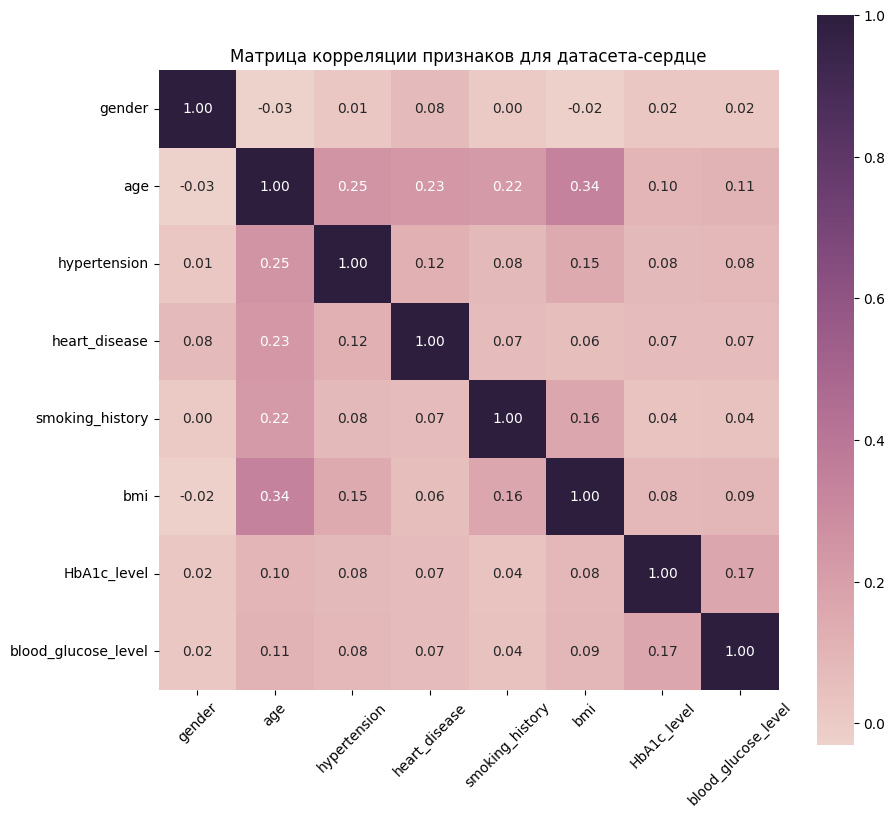

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Матрица корреляции признаков для датасета-сердце')
cmap = sns.diverging_palette(240, 0, s=70, l=80, as_cmap=True)
ax_sns = sns.heatmap(ax = ax, data=df_sc1.corr(), cmap=sns.cubehelix_palette(as_cmap=True), square=True, annot=True, fmt='.2f', linecolor='white')
ax_sns.set_xticklabels(ax_sns.get_xticklabels(), rotation=45)
ax_sns.set_yticklabels(ax_sns.get_yticklabels(), rotation=0)
plt.subplots_adjust(bottom=0.15)
plt.show()

Видно, что признаки совсем не коррелируют друг с другом. Наибольшая из представленных корреляций у "bmi" и "age"

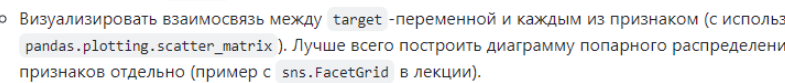

#### Выполним визуализацию взаимосвязи между target-переменной и каждым из признаков с помощью sns.pairplot

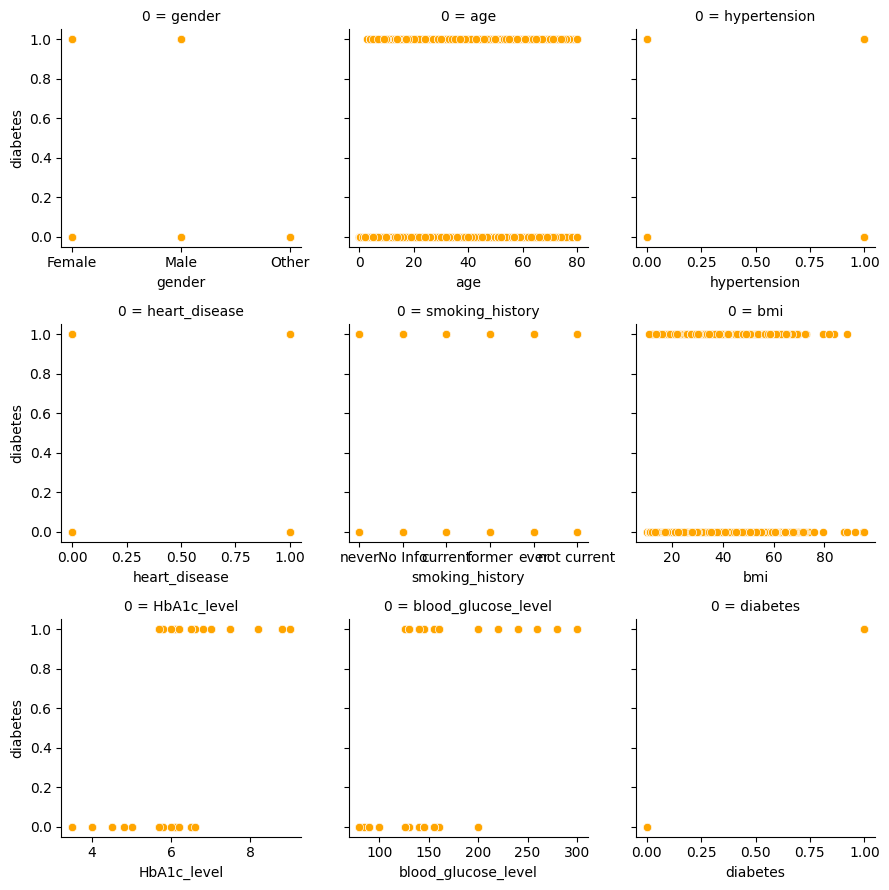

In [11]:
fig = sns.FacetGrid(pd.DataFrame(df.columns), col=0, col_wrap=3, sharex=False)

for ax, varx in zip(fig.axes, df.columns):
    sns.scatterplot(data=df[df.columns], x=varx, y='diabetes', ax=ax, color = 'orange')
    
fig.tight_layout()

Четкой линейной зависимости не наблюдается :( 

In [12]:
#Убираем закодированные категориальные признаки из датасета
col = ['gender', 'smoking_history']
df_ = df_sc1.drop(col, axis=1, inplace=False)
df_ 

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,1.000000,0.0,1.0,0.177171,0.563636,0.272727
1,0.674675,0.0,0.0,0.202031,0.563636,0.000000
2,0.349349,0.0,0.0,0.202031,0.400000,0.354545
3,0.449449,0.0,0.0,0.156863,0.272727,0.340909
4,0.949950,1.0,1.0,0.118231,0.236364,0.340909
...,...,...,...,...,...,...
99995,1.000000,0.0,0.0,0.202031,0.490909,0.045455
99996,0.024024,0.0,0.0,0.085901,0.545455,0.090909
99997,0.824825,0.0,0.0,0.207983,0.400000,0.340909
99998,0.299299,0.0,0.0,0.296569,0.090909,0.090909


#### Разбиение на обучающую и тестовую выборки

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_, df['diabetes'], test_size= 0.3, random_state= 42)

### 3. Регрессия МНК:

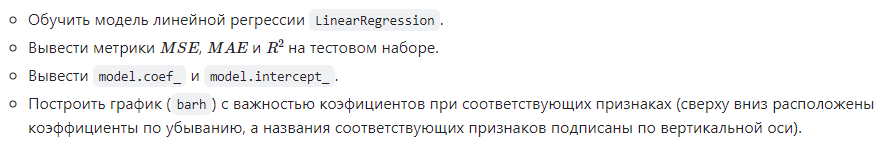

#### Обучение модели линейной регрессии

In [14]:
model_regr = LinearRegression()
model_regr.fit(X_train, y_train)
model_regr_pred = model_regr.predict(X_test)

#### Вывод метрик 

In [15]:
mse = mean_squared_error(y_test, model_regr_pred)
mae = mean_absolute_error(y_test, model_regr_pred)
r_2 = r2_score(y_test, model_regr_pred)

print('Средняя квадратичная ошибка (MSE): ', mse)
print('Средняя абсолютная ошибка (MAE): ', mae)
print('Коэффициент детерминации (R2 score): ', r_2)

Средняя квадратичная ошибка (MSE):  0.051088475948355215
Средняя абсолютная ошибка (MAE):  0.1546839422724272
Коэффициент детерминации (R2 score):  0.3424228681958693


Коэффициент детерминации близок к 0 - 0.34, что говорит о том, что между переменными регрессионной модели практически отсутствуют линейные зависимости.

In [16]:
model_regr.coef_

array([0.11457507, 0.09212756, 0.11868145, 0.35256489, 0.45138852,
       0.50444175])

In [17]:
df_features = pd.DataFrame(columns=df_.columns, data=np.reshape(model_regr.coef_, (1, -1)))
df_features

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,0.114575,0.092128,0.118681,0.352565,0.451389,0.504442


Высокие коэффициенты имеют признаки: "blood_glucose_level", "HbA1c_level" и "bmi".

In [18]:
model_regr.intercept_

-0.35753567878664766

([<matplotlib.axis.YTick at 0x189a5266e50>,
 [Text(0, 0, 'hypertension'),
  Text(0, 1, 'age'),
  Text(0, 2, 'heart_disease'),
  Text(0, 3, 'bmi'),
  Text(0, 4, 'HbA1c_level'),
  Text(0, 5, 'blood_glucose_level')])

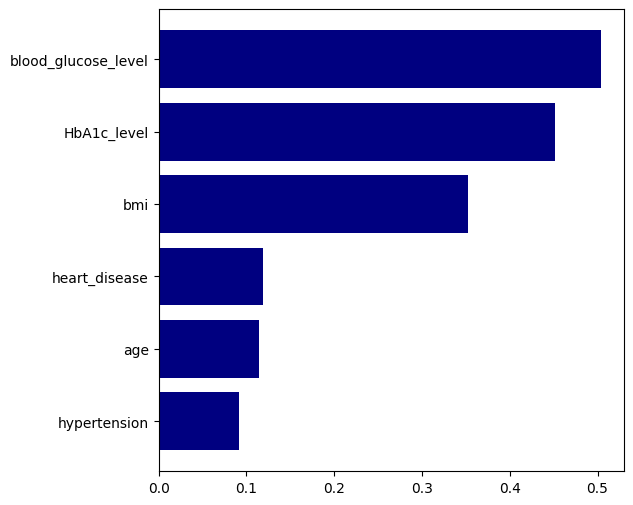

In [19]:
coef = []
name = []
z = zip(model_regr.coef_, df_.columns)
z = sorted(z, key=lambda x: x[0])
for c, n in z:
    coef.append(c)
    name.append(n)
    
plt.figure(figsize=(6,6))
plt.barh(range(len(model_regr.coef_)), coef, align='center', color = 'navy')
plt.yticks(range(len(model_regr.coef_)), name)    

### 4. Для каждого вида регрессии (Ridge, LASSO, Elastic Net):

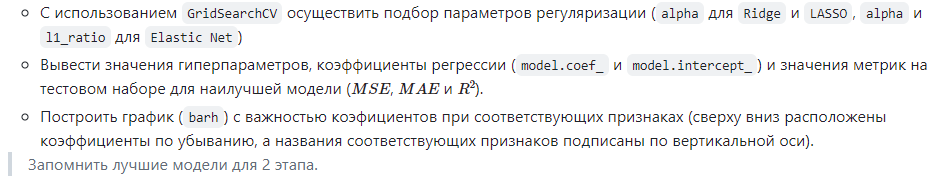

#### LASSO

In [20]:
lasso_reg = Lasso()

param = {"alpha": np.arange(0.2, 5, 0.1)}
lasso_grid_search = GridSearchCV(lasso_reg, param, refit= True, n_jobs= -1, verbose = 2)
lasso_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4,
       1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
       2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ,
       4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])},
             verbose=2)

In [21]:
print(f"Best params for Lasso: {lasso_grid_search.best_params_}")

Best params for Lasso: {'alpha': 0.2}


In [22]:
model_lasso = Lasso(alpha= 0.2)
model_lasso.fit(X_train, y_train)
model_lasso_pred = model_lasso.predict(X_test) 

mse_lasso = mean_squared_error(y_test, model_lasso_pred)
mae_lasso = mean_absolute_error(y_test, model_lasso_pred)
r_2_lasso = r2_score(y_test, model_lasso_pred)

print('Средняя квадратичная ошибка Lasso (MSE): ', mse_lasso)
print('Средняя абсолютная ошибка Lasso (MAE): ', mae_lasso)
print('Коэффициент детерминации Lasso (R2 score): ', r_2_lasso)

Средняя квадратичная ошибка Lasso (MSE):  0.07769201040816329
Средняя абсолютная ошибка Lasso (MAE):  0.15550258000000003
Коэффициент детерминации Lasso (R2 score):  -2.626804034289165e-07


In [23]:
df_features_lasso = pd.DataFrame(columns=df_.columns, data=np.reshape(model_lasso.coef_, (1, -1)))
df_features_lasso

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
model_lasso.intercept_

0.08504285714285714

([<matplotlib.axis.YTick at 0x189a51ad010>,
 [Text(0, 0, 'age'),
  Text(0, 1, 'hypertension'),
  Text(0, 2, 'heart_disease'),
  Text(0, 3, 'bmi'),
  Text(0, 4, 'HbA1c_level'),
  Text(0, 5, 'blood_glucose_level')])

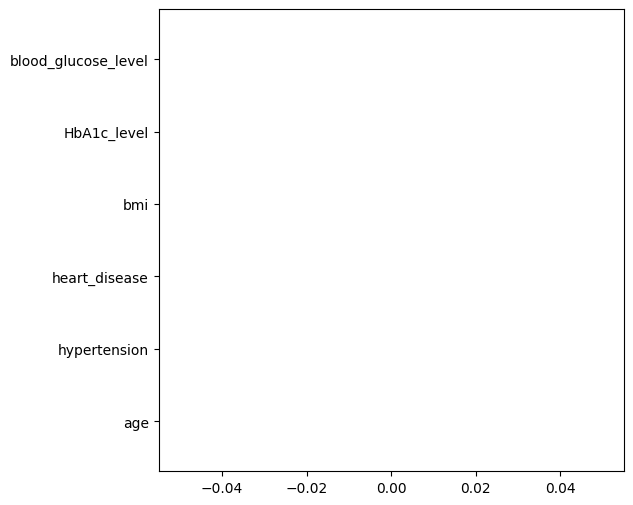

In [25]:
coef_lasso = []
name_lasso = []
z = zip(model_lasso.coef_, df_.columns)
z = sorted(z, key=lambda x: x[0])
for c, n in z:
    coef_lasso.append(c)
    name_lasso.append(n)
    
plt.figure(figsize=(6,6))
plt.barh(range(len(model_lasso.coef_)), coef_lasso, align='center', color = 'salmon')
plt.yticks(range(len(model_lasso.coef_)), name_lasso) 

#### Ridge

In [26]:
ridge_reg = Ridge()

param = {"alpha": np.arange(0.2, 8, 0.1)}
ridge_grid_search = GridSearchCV(ridge_reg, param, refit= True, n_jobs= -1, verbose = 2)
ridge_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 78 candidates, totalling 390 fits


GridSearchCV(estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4,
       1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
       2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ,
       4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3,
       5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6,
       6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9])},
             verbose=2)

In [27]:
print(f"Best params for Ridge: {ridge_grid_search.best_params_}")

Best params for Ridge: {'alpha': 1.6000000000000003}


In [28]:
model_ridge = Ridge(alpha= 1.6)
model_ridge.fit(X_train, y_train)
model_ridge_pred = model_ridge.predict(X_test) 

mse_ridge = mean_squared_error(y_test, model_ridge_pred)
mae_ridge = mean_absolute_error(y_test, model_ridge_pred)
r_2_ridge = r2_score(y_test, model_ridge_pred)

print('Средняя квадратичная ошибка Ridge (MSE): ', mse_ridge)
print('Средняя абсолютная ошибка Ridge (MAE): ', mae_ridge)
print('Коэффициент детерминации Ridge (R2 score): ', r_2_ridge)

Средняя квадратичная ошибка Ridge (MSE):  0.05108865315533426
Средняя абсолютная ошибка Ridge (MAE):  0.1546575718735343
Коэффициент детерминации Ridge (R2 score):  0.342420587304634


In [29]:
df_features_ridge = pd.DataFrame(columns=df_.columns, data=np.reshape(model_ridge.coef_, (1, -1)))
df_features_ridge

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,0.114709,0.092156,0.118628,0.351141,0.451186,0.504173


Результат получился схож с линейной регрессией

In [30]:
model_ridge.intercept_

-0.35717262042131354

([<matplotlib.axis.YTick at 0x189a4e07190>,
 [Text(0, 0, 'hypertension'),
  Text(0, 1, 'age'),
  Text(0, 2, 'heart_disease'),
  Text(0, 3, 'bmi'),
  Text(0, 4, 'HbA1c_level'),
  Text(0, 5, 'blood_glucose_level')])

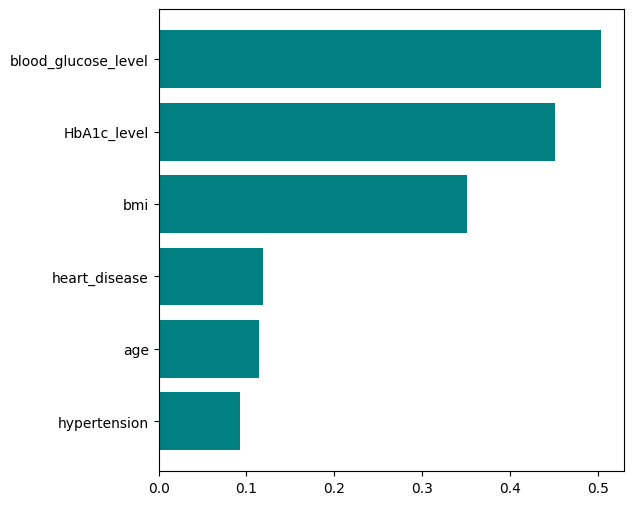

In [31]:
coef_ridge = []
name_ridge = []
z = zip(model_ridge.coef_, df_.columns)
z = sorted(z, key=lambda x: x[0])
for c, n in z:
    coef_ridge.append(c)
    name_ridge.append(n)
    
plt.figure(figsize=(6,6))
plt.barh(range(len(model_ridge.coef_)), coef_ridge, align='center', color = 'teal')
plt.yticks(range(len(model_ridge.coef_)), name_ridge) 

#### Elastic Net

In [32]:
elastic_net_reg = ElasticNet()

param = {"alpha": np.arange(0.2, 8, 0.1),
         "l1_ratio": [0.05, 0.2, 0.75]}

elastic_net_grid_search = GridSearchCV(elastic_net_reg, param, refit= True, n_jobs= -1, verbose = 2)
elastic_net_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 234 candidates, totalling 1170 fits


GridSearchCV(estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4,
       1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
       2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ,
       4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3,
       5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6,
       6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9]),
                         'l1_ratio': [0.05, 0.2, 0.75]},
             verbose=2)

In [33]:
print(f"Best params for Elastic Net: {elastic_net_grid_search.best_params_}")

Best params for Elastic Net: {'alpha': 0.2, 'l1_ratio': 0.05}


In [34]:
model_Elastic_Net = ElasticNet(alpha= 0.2, l1_ratio = 0.05)
model_Elastic_Net.fit(X_train, y_train)
model_Elastic_Net_pred = model_Elastic_Net.predict(X_test) 

mse_Elastic_Net = mean_squared_error(y_test, model_Elastic_Net_pred)
mae_Elastic_Net = mean_absolute_error(y_test, model_Elastic_Net_pred)
r_2_Elastic_Net = r2_score(y_test, model_Elastic_Net_pred)

print('Средняя квадратичная ошибка Elastic Net (MSE): ', mse_Elastic_Net)
print('Средняя абсолютная ошибка Elastic Net (MAE): ', mae_Elastic_Net)
print('Коэффициент детерминации Elastic Net (R2 score): ', r_2_Elastic_Net)

Средняя квадратичная ошибка Elastic Net (MSE):  0.07200399415320614
Средняя абсолютная ошибка Elastic Net (MAE):  0.14931218396014817
Коэффициент детерминации Elastic Net (R2 score):  0.07321212710337166


In [35]:
df_features_Elastic_Net = pd.DataFrame(columns=df_.columns, data=np.reshape(model_Elastic_Net.coef_, (1, -1)))
df_features_Elastic_Net

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,0.035184,0.012797,0.0,0.0,0.049799,0.050084


In [36]:
model_Elastic_Net.intercept_

0.03406369114059317

([<matplotlib.axis.YTick at 0x189a4e7e590>,
 [Text(0, 0, 'hypertension'),
  Text(0, 1, 'age'),
  Text(0, 2, 'heart_disease'),
  Text(0, 3, 'bmi'),
  Text(0, 4, 'HbA1c_level'),
  Text(0, 5, 'blood_glucose_level')])

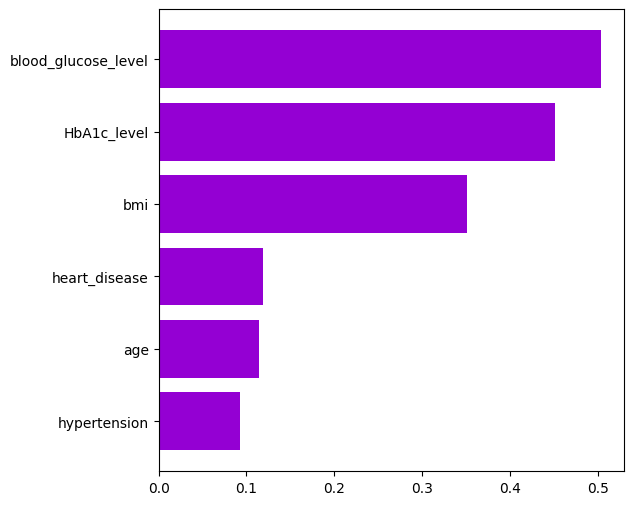

In [37]:
coef_ridge = []
name_ridge = []
z = zip(model_ridge.coef_, df_.columns)
z = sorted(z, key=lambda x: x[0])
for c, n in z:
    coef_ridge.append(c)
    name_ridge.append(n)
    
plt.figure(figsize=(6,6))
plt.barh(range(len(model_ridge.coef_)), coef_ridge, align='center', color = 'darkviolet')
plt.yticks(range(len(model_ridge.coef_)), name_ridge)

### 5. Датасет и подготовка данных, этап 2:

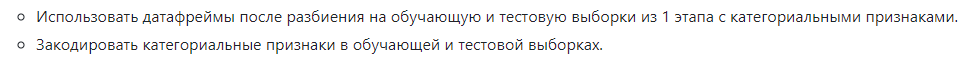

In [38]:
#Датасет с закодированными категориальными признаками "gender" и "smoking_history"
df_sc1

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,0.0,1.000000,0.0,1.0,0.2,0.177171,0.563636,0.272727
1,0.0,0.674675,0.0,0.0,0.0,0.202031,0.563636,0.000000
2,0.5,0.349349,0.0,0.0,0.2,0.202031,0.400000,0.354545
3,0.0,0.449449,0.0,0.0,0.6,0.156863,0.272727,0.340909
4,0.5,0.949950,1.0,1.0,0.6,0.118231,0.236364,0.340909
...,...,...,...,...,...,...,...,...
99995,0.0,1.000000,0.0,0.0,0.0,0.202031,0.490909,0.045455
99996,0.0,0.024024,0.0,0.0,0.0,0.085901,0.545455,0.090909
99997,0.5,0.824825,0.0,0.0,0.4,0.207983,0.400000,0.340909
99998,0.0,0.299299,0.0,0.0,0.2,0.296569,0.090909,0.090909


In [39]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(df_sc1, df['diabetes'], test_size= 0.3, random_state= 42)

### 6. Регрессии, этап 2: 

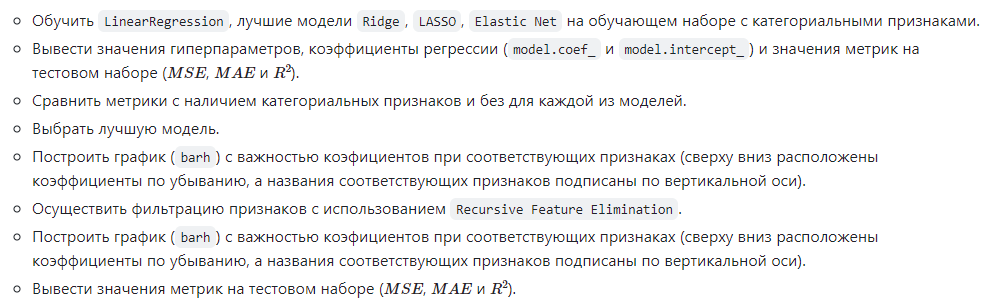

In [40]:
def print_metrics(model, x_test, y_test): 
    model_pred = model.predict(x_test)
    return print(f"MSE: {mean_squared_error(y_test, model_pred)} \nMAE: {mean_absolute_error(y_test, model_pred)} \nR2 score: {r2_score(y_test, model_pred)}")
#     print(f"MAE: {mean_absolute_error(y_test, model_pred)}")     
#     print(f"R2 score: {r2_score(y_test, model_pred)}") 

In [41]:
model_regr_ = LinearRegression()
model_regr_.fit(X_train_, y_train_)
model_regr_pred_ = model_regr_.predict(X_test_)

model_lasso_ = Lasso(alpha= 0.2)
model_lasso_.fit(X_train_, y_train_)
model_lasso_pred_ = model_lasso_.predict(X_test_) 

model_ridge_ = Ridge(alpha= 1.6)
model_ridge_.fit(X_train_, y_train_)
model_ridge_pred_ = model_ridge_.predict(X_test_) 

model_Elastic_Net_ = ElasticNet(alpha= 0.2, l1_ratio = 0.05)
model_Elastic_Net_.fit(X_train_, y_train_)
model_Elastic_Net_pred_ = model_Elastic_Net_.predict(X_test_)

In [42]:
print('**Для модели регрессии МНК:** ')
print(print_metrics(model_regr_, X_test_, y_test_))
print('**Для модели lasso:** ')
print(print_metrics(model_lasso_, X_test_, y_test_))
print('**Для модели ridge:** ')
print(print_metrics(model_ridge_, X_test_, y_test_))
print('**Для модели Elastic Net:** ')
print(print_metrics(model_Elastic_Net_, X_test_, y_test_))

**Для модели регрессии МНК:** 
MSE: 0.05101457468493639 
MAE: 0.1546565513895005 
R2 score: 0.34337407646610185
None
**Для модели lasso:** 
MSE: 0.07769201040816329 
MAE: 0.15550258000000003 
R2 score: -2.626804034289165e-07
None
**Для модели ridge:** 
MSE: 0.05101476641211389 
MAE: 0.15463037495176038 
R2 score: 0.3433716086804589
None
**Для модели Elastic Net:** 
MSE: 0.07200399415320614 
MAE: 0.14931218396014817 
R2 score: 0.07321212710337166
None


In [43]:
#Результаты на датасете без категориальных признаков
print('**Для модели регрессии МНК:** ')
print(print_metrics(model_regr, X_test, y_test))
print('**Для модели lasso:** ')
print(print_metrics(model_lasso, X_test, y_test))
print('**Для модели ridge:** ')
print(print_metrics(model_ridge, X_test, y_test))
print('**Для модели Elastic Net:** ')
print(print_metrics(model_Elastic_Net, X_test, y_test))

**Для модели регрессии МНК:** 
MSE: 0.051088475948355215 
MAE: 0.1546839422724272 
R2 score: 0.3424228681958693
None
**Для модели lasso:** 
MSE: 0.07769201040816329 
MAE: 0.15550258000000003 
R2 score: -2.626804034289165e-07
None
**Для модели ridge:** 
MSE: 0.05108865315533426 
MAE: 0.1546575718735343 
R2 score: 0.342420587304634
None
**Для модели Elastic Net:** 
MSE: 0.07200399415320614 
MAE: 0.14931218396014817 
R2 score: 0.07321212710337166
None


В данном датасете никакую роль не играют категориальные признаки, видимо изначально был неправильно подобран датасет, где все признаки между собой никак не коррелируют, отсюда результаты регрессии плохие.

Все модели показали ужасный результат. Выберем "наименьшее из зол". В качестве лучшей модели будем считать модель линейной регрессии для данных вместе с категориальными признаками.

([<matplotlib.axis.YTick at 0x189a4de8150>,
 [Text(0, 0, 'smoking_history'),
  Text(0, 1, 'gender'),
  Text(0, 2, 'hypertension'),
  Text(0, 3, 'age'),
  Text(0, 4, 'heart_disease'),
  Text(0, 5, 'bmi'),
  Text(0, 6, 'HbA1c_level'),
  Text(0, 7, 'blood_glucose_level')])

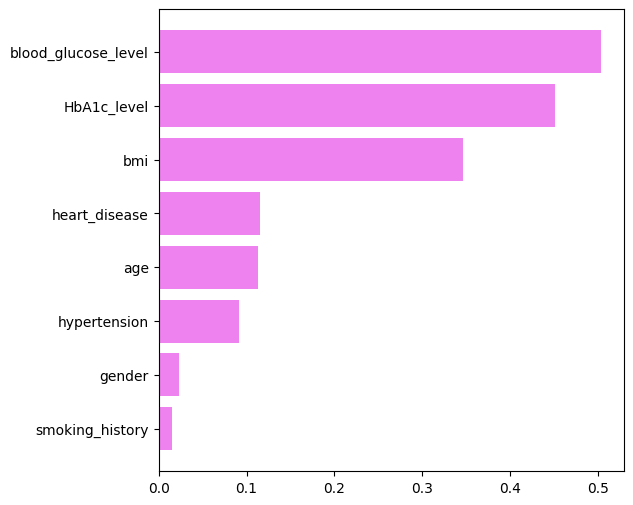

In [44]:
coef_ridge_ = []
name_ridge_ = []
z = zip(model_ridge_.coef_, df_sc1.columns)
z = sorted(z, key=lambda x: x[0])
for c, n in z:
    coef_ridge_.append(c)
    name_ridge_.append(n)
    
plt.figure(figsize=(6,6))
plt.barh(range(len(model_regr_.coef_)), coef_ridge_, align='center', color = 'violet')
plt.yticks(range(len(model_regr_.coef_)), name_ridge_)

In [45]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

rfe = RFE(estimator=LinearRegression(), n_features_to_select=4)
model = LinearRegression()

rf_pipeline = Pipeline(steps=[('rfe', rfe), ('model', model)])
rf_pipeline.fit(X_train_, y_train_)

print(f"Выбранные признаки:\n{rf_pipeline.named_steps['rfe'].get_feature_names_out()}")
print(f"Коэффициенты регрессии:\n{model.coef_}")
print("Метрики модели: ")
print(print_metrics(rf_pipeline, X_test_, y_test_))

Выбранные признаки:
['age' 'bmi' 'HbA1c_level' 'blood_glucose_level']
Коэффициенты регрессии:
[0.15264789 0.36721238 0.46241792 0.51524068]
Метрики модели: 
MSE: 0.05239252313420428 
MAE: 0.15735480242194513 
R2 score: 0.3256380338024001
None


([<matplotlib.axis.YTick at 0x189a92792d0>,
 [Text(0, 0, 'gender'),
  Text(0, 1, 'age'),
  Text(0, 2, 'hypertension'),
  Text(0, 3, 'heart_disease')])

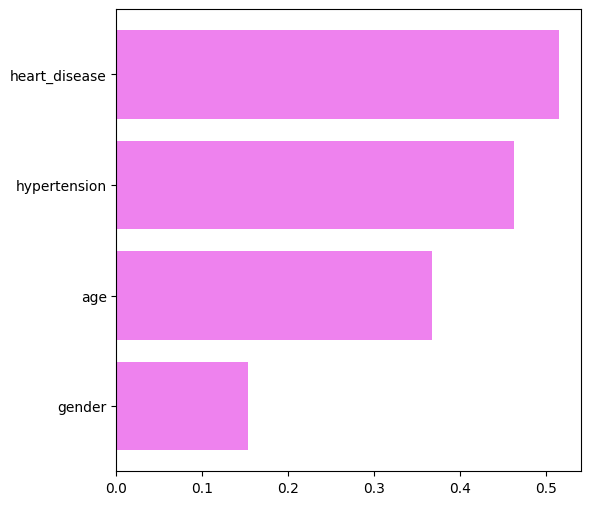

In [46]:
coef_ridge_ = []
name_ridge_ = []
z = zip(model.coef_, df_sc1.columns)
z = sorted(z, key=lambda x: x[0])
for c, n in z:
    coef_ridge_.append(c)
    name_ridge_.append(n)
    
plt.figure(figsize=(6,6))
plt.barh(range(len(model.coef_)), coef_ridge_, align='center', color = 'violet')
plt.yticks(range(len(model.coef_)), name_ridge_)

### 7. Сделать вывод:

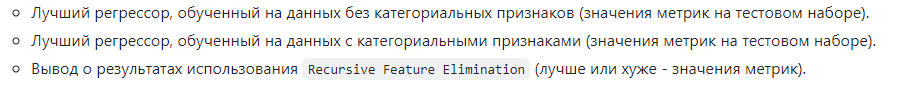

Датасет не предназначен для регрессии (P.S. я пробовала еще два датасета с сердцем и с космическими объектами, там результаты были более разнообразными, но не было категориальных признаков, поэтому решила оставить с диабетом :(, но как оказалось результат тоже не порадовал). Наиболее преемлемый результат получился на наборе данных с категориальными признаками (по идее наличие дополнительных некоррелированных признаков должно давать больше информации для предсказания класса, поэтому и результат должен быть лучше), используя модели линейной регрессии и ridge. Лучшие регрессоры и для данных с категориальными признаками, и для данных без категориальных признаков - линейная регрессия и ridge. После отбора признаков с помощью RFE результат регрессии стал чуть меньше, что и ожидалось (поскольку были удалены признаки, несущие информацию о пресказании классов), возможно если бы в датасете было бы большое число признаков, которые являлись практически шумовой компонентой для предсказания класса, фильтрация признаков с помощью RFE дала бы более хороший результат. 